# Data generation (Hilal hoca silhouette.py & silhouette_2.py)
- run with metric-dev
- Part A: n_cells x 2 data
- Part B: n_cells x 2000 data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import pandas as pd
import scanpy as sc
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

In [2]:
np.random.seed(42)

In [3]:
def from_2d_to_highd(Z, n_features=2000, noise_sigma=0.1, random_state=42):
    """
    Convert 2D data matrix Z (n_cells x 2) to high-dimensional data matrix X (n_cells x n_features)
    using random orthogonal projection with added Gaussian noise.

    Parameters:
    Z : np.ndarray
        Input data matrix of shape (n_cells, 2).
    n_genes : int
        Number of genes (dimensions) for the output data matrix X.

    Returns:
    X : np.ndarray
        Output data matrix of shape (n_cells, n_genes).
    """

    rng = np.random.default_rng(random_state)
    A = rng.normal(size=(n_features, 2))   # random tall matrix
    Q, _ = np.linalg.qr(A)                 # orthonormal columns (D x 2)
    W = Q
    X_signal = Z @ W.T                     # (N x D)
    E = rng.normal(scale=noise_sigma, size=X_signal.shape)
    X = X_signal + E
    return X, W

In [4]:
def pca2(X, random_state=42):
    pca = PCA(n_components=2, random_state=random_state)
    PC = pca.fit_transform(X)
    return PC, pca

In [5]:
def plot_pc2(PC, batches, cell_types, file, title="PCA (color=batch, marker=cell type)"):
    df = pd.DataFrame(PC, columns=["PC1","PC2"])
    df["batch"] = np.array(batches)
    df["cell_type"] = np.array(cell_types)

    batch_order = sorted(df["batch"].unique())
    ctype_order = sorted(df["cell_type"].unique())

    # colors from Matplotlib cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    batch2color = {b: colors[i % len(colors)] for i, b in enumerate(batch_order)}

    # a few marker shapes for types
    markers = ['o','s','^','D','P','X','v','*']
    ctype2marker = {ct: markers[i % len(markers)] for i, ct in enumerate(ctype_order)}

    plt.figure(figsize=(7.5, 6.5))
    for ct in ctype_order:
        for b in batch_order:
            m = (df["cell_type"]==ct) & (df["batch"]==b)
            if not m.any(): 
                continue
            plt.scatter(
                df.loc[m,"PC1"], df.loc[m,"PC2"],
                s=10, alpha=0.7,
                marker=ctype2marker[ct],
                c=batch2color[b],
                edgecolor='none',
                label=f"{ct} • {b}"
            )

    # dual legends (clean)
    batch_handles = [Line2D([0],[0], marker='o', linestyle='', color=batch2color[b], label=b) 
                     for b in batch_order]
    ctype_handles = [Line2D([0],[0], marker=ctype2marker[ct], linestyle='', color='black', label=ct)
                     for ct in ctype_order]

    leg1 = plt.legend(handles=batch_handles, title="Batch", loc='upper right')
    plt.gca().add_artist(leg1)
    plt.legend(handles=ctype_handles, title="Cell Type", loc='lower right')

    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(title)
    plt.tight_layout()
    plt.savefig(file, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
# Function to generate ellipse-shaped clusters
def generate_elliptical_data(n_samples=500, centers=[(0, 2), (0, -2)], stretch_x=8, stretch_y=1):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.5, random_state=42)

    # Stretching in x-direction to form ellipses
    # X[:, 0] *= stretch_x
    # X[:, 1] *= stretch_y

    return X, y

In [7]:
# Function to apply rotation
def rotate(X, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    
    # Counter-clockwise rotation
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    return X @ rotation_matrix.T    # matrix multiplication

In [8]:
def generate_intersecting_diagonal_ellipses(n_samples=500, centers=[(-2, 1), (-2, -1)], angle_deg=30):
    n = n_samples // 2

    # Cluster 1: centered at (-2, 1)
    X1, _ = make_blobs(n_samples=n, centers= [centers[0]], cluster_std=1, random_state=42)
    X1[:, 0] *= 2.5 # Stretch along x-axis
    X1[:, 1] * 0.4  # Compress along y-axis
    X1 = rotate(X1, -angle_deg)    # Rotate clockwise

    # Cluster 2: centered at (-2, -1)
    X2, _ = make_blobs(n_samples=n, centers=[centers[1]], cluster_std=1, random_state=24)
    X2[:, 0] *= 2.5 # Stretch along x-axis
    X2[:, 1] * 0.4  # Compress along y-axis
    X2 = rotate(X2, angle_deg)    # Rotate counter-clockwise

    # Combine
    X = np.vstack((X1, X2))
    y = np.array([0]*n + [1]*n)
    
    return X, y

### Circular

In [9]:
# Generate data
X, y = generate_elliptical_data()

In [10]:
X.shape, X[:5]

((500, 2),
 array([[-0.26136151, -1.47549539],
        [-0.36356859, -2.12375932],
        [-0.32328644,  1.459226  ],
        [-0.30085331,  2.92613909],
        [-0.43020668, -2.19227777]]))

In [11]:
y.shape, y[:5]

((500,), array([1, 1, 0, 0, 1]))

##### Part A

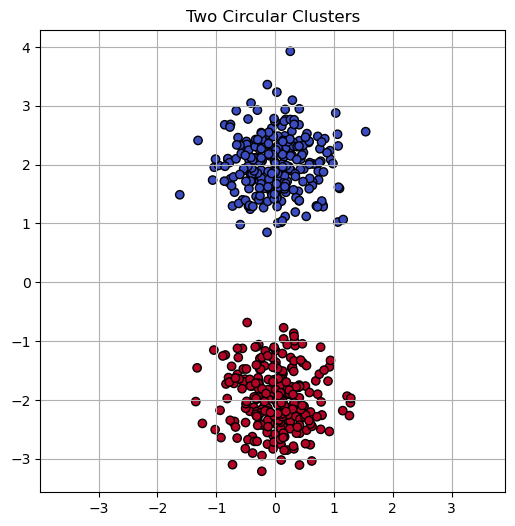

In [12]:
# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Two Circular Clusters")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_circular.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
cell_types = ['Type1'] * X.shape[0]
cell_types[:5]

['Type1', 'Type1', 'Type1', 'Type1', 'Type1']

In [14]:
batches = [f"Batch{b}" for b in y]
batches[:5]

['Batch1', 'Batch1', 'Batch0', 'Batch0', 'Batch1']

In [15]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['batch'] = batches
df['cell_type'] = cell_types

df

,X,Y,batch,cell_type
0,-0.261362,-1.475495,Batch1,Type1
1,-0.363569,-2.123759,Batch1,Type1
2,-0.323286,1.459226,Batch0,Type1
3,-0.300853,2.926139,Batch0,Type1
4,-0.430207,-2.192278,Batch1,Type1
...,...,...,...,...
495,0.303948,-1.906695,Batch1,Type1
496,-0.181806,-2.028473,Batch1,Type1
497,-0.889360,-1.251978,Batch1,Type1
498,0.710252,-2.285373,Batch1,Type1


In [16]:
pd.crosstab(df['batch'], df['cell_type'])

cell_type,Type1
batch,
Batch0,250
Batch1,250


In [17]:
adata = sc.AnnData(np.random.rand(X.shape[0], 400))
adata.obs = df

In [18]:
adata.obsm["X_pca"] = np.array(df[["X", "Y"]])
adata.obsm["X_umap"] = np.array(df[["X", "Y"]])

In [19]:
adata

AnnData object with n_obs × n_vars = 500 × 400
    obs: 'X', 'Y', 'batch', 'cell_type'
    obsm: 'X_pca', 'X_umap'

In [20]:
# adata.write("sil_circular.h5ad")

##### Part B

In [21]:
X_highd, _ = from_2d_to_highd(X)
X_highd.shape, X_highd[:5]

((500, 2000),
 array([[-0.00742961,  0.12380994, -0.02428879, ...,  0.14180227,
          0.01685449, -0.18237083],
        [-0.02471378,  0.04380527,  0.01265772, ..., -0.160312  ,
          0.03732164, -0.03844391],
        [ 0.06973765,  0.09954701,  0.14709738, ...,  0.0357295 ,
          0.12914012,  0.01682075],
        [ 0.08819231,  0.03574486, -0.08081326, ...,  0.13359544,
         -0.06783083, -0.06426454],
        [-0.0793514 ,  0.05767566, -0.20261177, ..., -0.00089398,
         -0.01544749, -0.05631244]]))

In [22]:
PC, pca = pca2(X_highd)
PC.shape, PC[:5]

((500, 2),
 array([[-1.49983533, -0.46137087],
        [-1.85818549, -0.39135568],
        [ 1.3368733 , -0.37728915],
        [ 2.88921888, -0.27847998],
        [-2.19700733, -0.53879586]]))

In [23]:
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])

Explained variance ratio (PC1, PC2): [0.17403635 0.01157834]


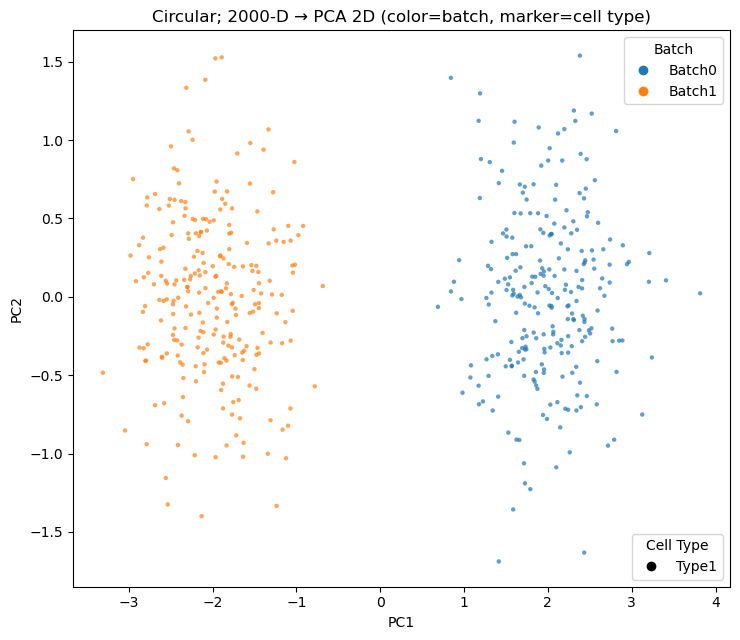

In [24]:
# Plot (color=batch, shape=cell type)
plot_pc2(PC, batches=batches, cell_types=cell_types,
         file="pca_sil_circular.png",
         title="Circular; 2000-D → PCA 2D (color=batch, marker=cell type)")

In [25]:
X_highd.shape

(500, 2000)

In [26]:
adata = sc.AnnData(X_highd)
adata

AnnData object with n_obs × n_vars = 500 × 2000

In [27]:
adata.obs['batch'] = batches
adata.obs['cell_type'] = cell_types
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'

In [28]:
adata.write("sil_circular_n_genes_2000.h5ad")

### Stretch clusters

##### Part A

In [29]:
X

array([[-2.61361510e-01, -1.47549539e+00],
       [-3.63568588e-01, -2.12375932e+00],
       [-3.23286442e-01,  1.45922600e+00],
       [-3.00853306e-01,  2.92613909e+00],
       [-4.30206683e-01, -2.19227777e+00],
       [ 8.54327191e-02, -2.09199167e+00],
       [-2.77599763e-01, -1.05942147e+00],
       [-5.10616409e-01, -1.64582178e+00],
       [ 8.14307773e-01,  1.30994927e+00],
       [-3.81629578e-01, -2.90244105e+00],
       [ 2.46658950e-01, -1.90758194e+00],
       [-4.19608762e-01,  1.84539381e+00],
       [-2.69879840e-01, -2.38915236e+00],
       [-2.58805650e-01, -1.88810602e+00],
       [-9.61804824e-02,  2.15077367e+00],
       [ 3.95515974e-01,  1.54530627e+00],
       [-6.74861237e-03,  1.47114454e+00],
       [-2.65250574e-01,  1.71209088e+00],
       [ 1.83299123e-01,  1.53006011e+00],
       [ 3.40945745e-01, -1.07664634e+00],
       [ 4.87559867e-01,  1.92647131e+00],
       [ 1.65631716e-01,  2.48777256e+00],
       [-4.90754326e-01,  2.23105174e+00],
       [-4.

In [30]:
stretch_x = 8
stretch_y = 1

In [31]:
# Stretching in x-direction to form ellipses
X[:, 0] *= stretch_x
X[:, 1] *= stretch_y

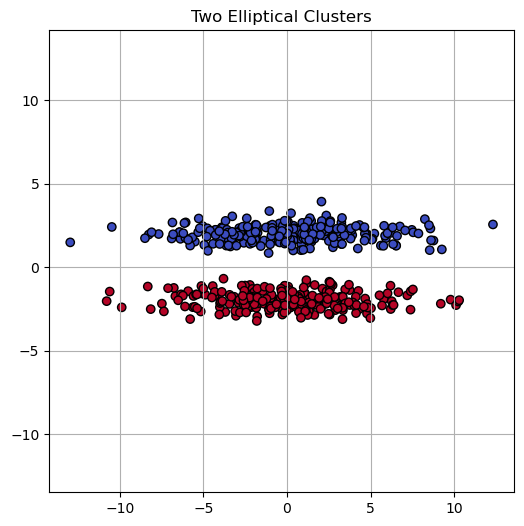

In [32]:
# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Two Elliptical Clusters")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_elliptical.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['batch'] = batches
df['cell_type'] = cell_types

df

,X,Y,batch,cell_type
0,-2.090892,-1.475495,Batch1,Type1
1,-2.908549,-2.123759,Batch1,Type1
2,-2.586292,1.459226,Batch0,Type1
3,-2.406826,2.926139,Batch0,Type1
4,-3.441653,-2.192278,Batch1,Type1
...,...,...,...,...
495,2.431586,-1.906695,Batch1,Type1
496,-1.454449,-2.028473,Batch1,Type1
497,-7.114881,-1.251978,Batch1,Type1
498,5.682017,-2.285373,Batch1,Type1


In [34]:
pd.crosstab(df['batch'], df['cell_type'])

cell_type,Type1
batch,
Batch0,250
Batch1,250


In [35]:
adata = sc.AnnData(np.random.rand(X.shape[0], 400))
adata.obs = df

In [36]:
adata.obsm["X_pca"] = np.array(df[["X", "Y"]])
adata.obsm["X_umap"] = np.array(df[["X", "Y"]])

In [37]:
adata

AnnData object with n_obs × n_vars = 500 × 400
    obs: 'X', 'Y', 'batch', 'cell_type'
    obsm: 'X_pca', 'X_umap'

In [38]:
# adata.write("sil_elliptical.h5ad")

##### Part B

In [39]:
X_highd, _ = from_2d_to_highd(X)
X_highd.shape, X_highd[:5]

((500, 2000),
 array([[ 0.00511328,  0.15470033, -0.10459811, ...,  0.16657775,
          0.05849688, -0.20911008],
        [-0.00726591,  0.08677554, -0.09905707, ..., -0.12584791,
          0.09524855, -0.07563973],
        [ 0.08525235,  0.13775632,  0.0477602 , ...,  0.06637508,
          0.18064893, -0.0162539 ],
        [ 0.10263044,  0.07130279, -0.17325735, ...,  0.1621145 ,
         -0.01989626, -0.09504411],
        [-0.05870553,  0.1085219 , -0.33480265, ...,  0.039887  ,
          0.05309677, -0.10032583]]))

In [40]:
PC, pca = pca2(X_highd)
PC.shape, PC[:5]

((500, 2),
 array([[ 2.24090345, -1.51107853],
        [ 2.86541229, -1.87209151],
        [ 2.66720208,  1.32382828],
        [ 2.38760348,  2.87774754],
        [ 3.51960904, -2.21428492]]))

In [41]:
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])

Explained variance ratio (PC1, PC2): [0.38270662 0.10867475]


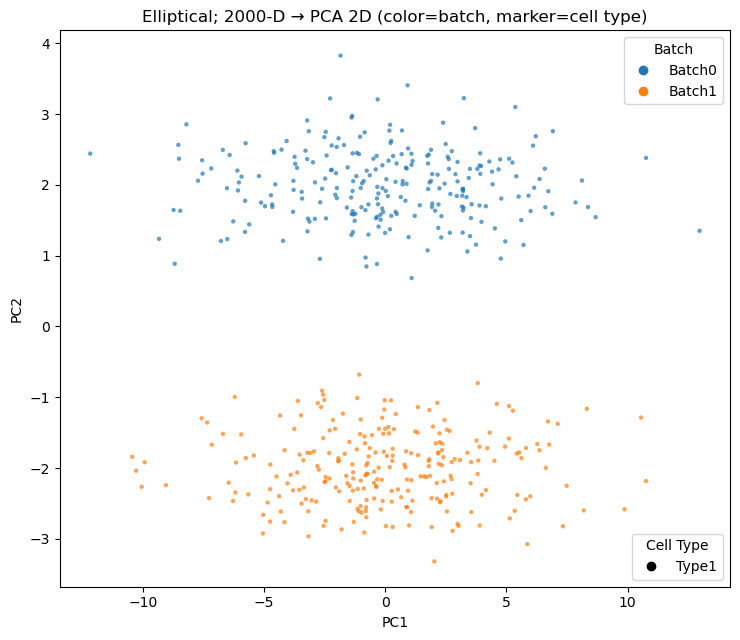

In [42]:
# Plot (color=batch, shape=cell type)
plot_pc2(PC, batches=batches, cell_types=cell_types,
        file="pca_sil_elliptical.png",
        title="Elliptical; 2000-D → PCA 2D (color=batch, marker=cell type)")

In [43]:
X_highd.shape

(500, 2000)

In [44]:
adata = sc.AnnData(X_highd)
adata

AnnData object with n_obs × n_vars = 500 × 2000

In [45]:
adata.obs['batch'] = batches
adata.obs['cell_type'] = cell_types
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'

In [46]:
adata.write("sil_elliptical_n_genes_2000.h5ad")

### Distant

In [47]:
# Generate data
X, y = generate_elliptical_data(centers=[(0, 10), (0, -10)])

##### Part A

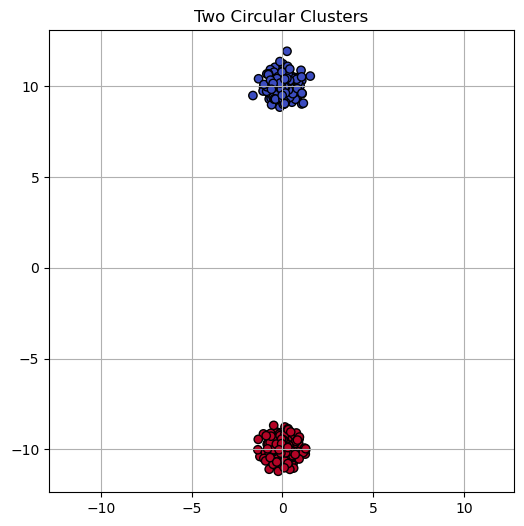

In [48]:
# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Two Circular Clusters")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_circular.png", dpi=300, bbox_inches='tight')
plt.show()

In [49]:
stretch_x = 8
stretch_y = 1

In [50]:
# Stretching in x-direction to form ellipses
X[:, 0] *= stretch_x
X[:, 1] *= stretch_y

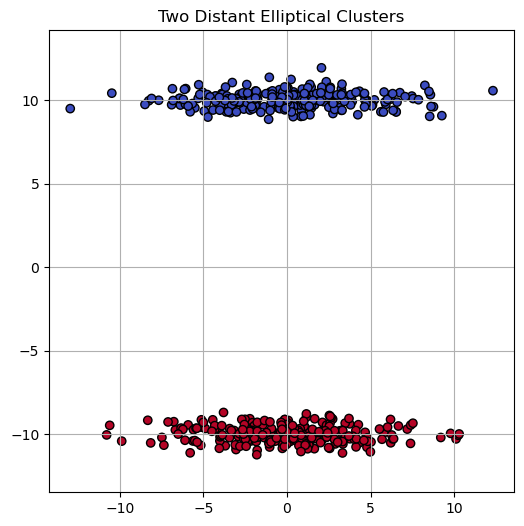

In [51]:
# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Two Distant Elliptical Clusters")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_elliptical_distant.png", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
cell_types = ['Type1'] * X.shape[0]
cell_types[:5]

['Type1', 'Type1', 'Type1', 'Type1', 'Type1']

In [53]:
batches = [f"Batch{b}" for b in y]
batches[:5]

['Batch1', 'Batch1', 'Batch0', 'Batch0', 'Batch1']

In [54]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['batch'] = batches
df['cell_type'] = cell_types

df

,X,Y,batch,cell_type
0,-2.090892,-9.475495,Batch1,Type1
1,-2.908549,-10.123759,Batch1,Type1
2,-2.586292,9.459226,Batch0,Type1
3,-2.406826,10.926139,Batch0,Type1
4,-3.441653,-10.192278,Batch1,Type1
...,...,...,...,...
495,2.431586,-9.906695,Batch1,Type1
496,-1.454449,-10.028473,Batch1,Type1
497,-7.114881,-9.251978,Batch1,Type1
498,5.682017,-10.285373,Batch1,Type1


In [55]:
pd.crosstab(df['batch'], df['cell_type'])

cell_type,Type1
batch,
Batch0,250
Batch1,250


In [56]:
adata = sc.AnnData(np.random.rand(X.shape[0], 400))
adata.obs = df

In [57]:
adata.obsm["X_pca"] = np.array(df[["X", "Y"]])
adata.obsm["X_umap"] = np.array(df[["X", "Y"]])

In [58]:
adata

AnnData object with n_obs × n_vars = 500 × 400
    obs: 'X', 'Y', 'batch', 'cell_type'
    obsm: 'X_pca', 'X_umap'

In [59]:
# adata.write("sil_elliptical_distant.h5ad")

##### Part B

In [60]:
X_highd, _ = from_2d_to_highd(X)
X_highd.shape, X_highd[:5]

((500, 2000),
 array([[-0.18216974,  0.31668086, -0.3222777 , ...,  0.04143372,
          0.00747091, -0.42747619],
        [-0.19454893,  0.24875607, -0.31673666, ..., -0.25099194,
          0.04422259, -0.29400583],
        [ 0.27253537, -0.02422422,  0.26543979, ...,  0.19151911,
          0.23167489,  0.2021122 ],
        [ 0.28991345, -0.09067775,  0.04442224, ...,  0.28725853,
          0.0311297 ,  0.12332199],
        [-0.24598854,  0.27050243, -0.55248224, ..., -0.08525703,
          0.00207081, -0.31869193]]))

In [61]:
PC, pca = pca2(X_highd)
PC.shape, PC[:5]

((500, 2),
 array([[ -9.4919399 ,   2.25836969],
        [ -9.84865074,   2.88491864],
        [  9.31863508,   2.65076901],
        [ 10.8885823 ,   2.36228192],
        [-10.19292719,   3.5410707 ]]))

In [62]:
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])

Explained variance ratio (PC1, PC2): [0.74176131 0.11087718]


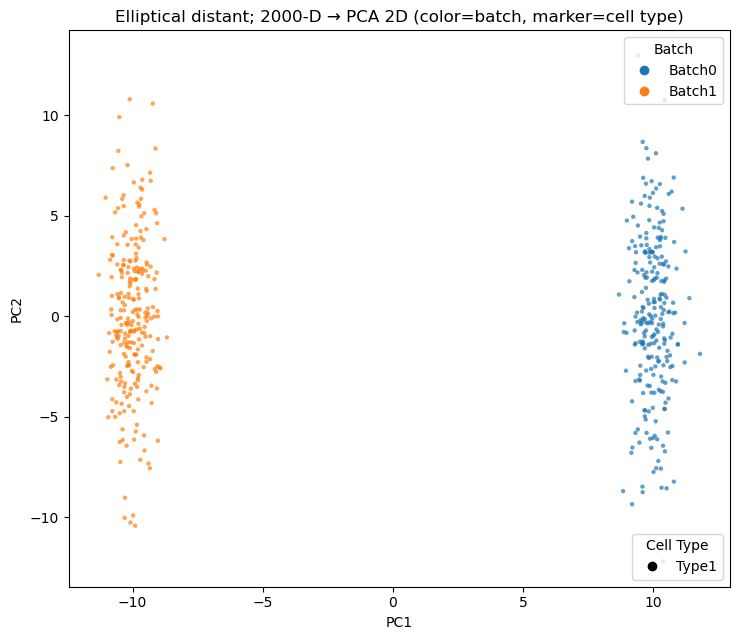

In [63]:
# Plot (color=batch, shape=cell type)
plot_pc2(PC, batches=batches, cell_types=cell_types,
         file="pca_sil_elliptical_distant.png",
         title="Elliptical distant; 2000-D → PCA 2D (color=batch, marker=cell type)")

In [64]:
X_highd.shape

(500, 2000)

In [65]:
adata = sc.AnnData(X_highd)
adata

AnnData object with n_obs × n_vars = 500 × 2000

In [66]:
adata.obs['batch'] = batches
adata.obs['cell_type'] = cell_types
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'

In [67]:
adata.write("sil_elliptical_distant_n_genes_2000.h5ad")

### Rotate 30 degrees

In [68]:
# Generate the data
X, y = generate_intersecting_diagonal_ellipses()

##### Part A

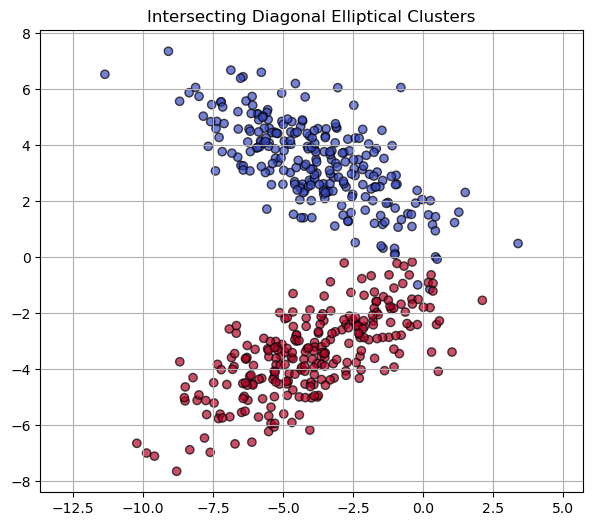

In [69]:
# Plot the data
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Intersecting Diagonal Elliptical Clusters")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_intersecting_diagonal.png", dpi=300, bbox_inches='tight')
plt.show()

In [70]:
cell_types = ['Type1'] * X.shape[0]
cell_types[:5]

['Type1', 'Type1', 'Type1', 'Type1', 'Type1']

In [71]:
batches = [f"Batch{b}" for b in y]
batches[:5]

['Batch0', 'Batch0', 'Batch0', 'Batch0', 'Batch0']

In [72]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['batch'] = batches
df['cell_type'] = cell_types

df

,X,Y,batch,cell_type
0,0.263462,2.020621,Batch0,Type1
1,-0.958351,2.924831,Batch0,Type1
2,-5.039006,4.848704,Batch0,Type1
3,-4.127174,3.949884,Batch0,Type1
4,-2.053209,2.155440,Batch0,Type1
...,...,...,...,...
495,-4.003534,-4.470025,Batch1,Type1
496,-9.870468,-6.996171,Batch1,Type1
497,-7.474813,-4.485340,Batch1,Type1
498,-4.019489,-4.619443,Batch1,Type1


In [73]:
pd.crosstab(df['batch'], df['cell_type'])

cell_type,Type1
batch,
Batch0,250
Batch1,250


In [74]:
adata = sc.AnnData(np.random.rand(X.shape[0], 400))
adata.obs = df

In [75]:
adata.obsm["X_pca"] = np.array(df[["X", "Y"]])
adata.obsm["X_umap"] = np.array(df[["X", "Y"]])

In [76]:
adata

AnnData object with n_obs × n_vars = 500 × 400
    obs: 'X', 'Y', 'batch', 'cell_type'
    obsm: 'X_pca', 'X_umap'

In [77]:
# adata.write("sil_intersecting_diagonal.h5ad")

##### Part B

In [78]:
X_highd, _ = from_2d_to_highd(X)
X_highd.shape, X_highd[:5]

((500, 2000),
 array([[ 0.07081771,  0.04416081,  0.09387806, ...,  0.18938488,
          0.02720795, -0.07927119],
        [ 0.09755332, -0.04837389,  0.12392094, ..., -0.07328235,
          0.08306078,  0.09066824],
        [ 0.18141662,  0.11054006,  0.03232303, ...,  0.15261133,
          0.25809468,  0.04041717],
        [ 0.13839104,  0.07962135, -0.22091793, ...,  0.20142587,
          0.02579068, -0.09224373],
        [ 0.03355729, -0.00295176, -0.15555411, ...,  0.08909606,
          0.04922486,  0.03864107]]))

In [79]:
PC, pca = pca2(X_highd)
PC.shape, PC[:5]

((500, 2),
 array([[ 2.23461124, -3.9523298 ],
        [ 3.39054668, -2.87919556],
        [ 4.71813486,  1.38513894],
        [ 3.9690226 ,  0.35844666],
        [ 2.28801183, -1.6883252 ]]))

In [80]:
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])

Explained variance ratio (PC1, PC2): [0.35732042 0.13318754]


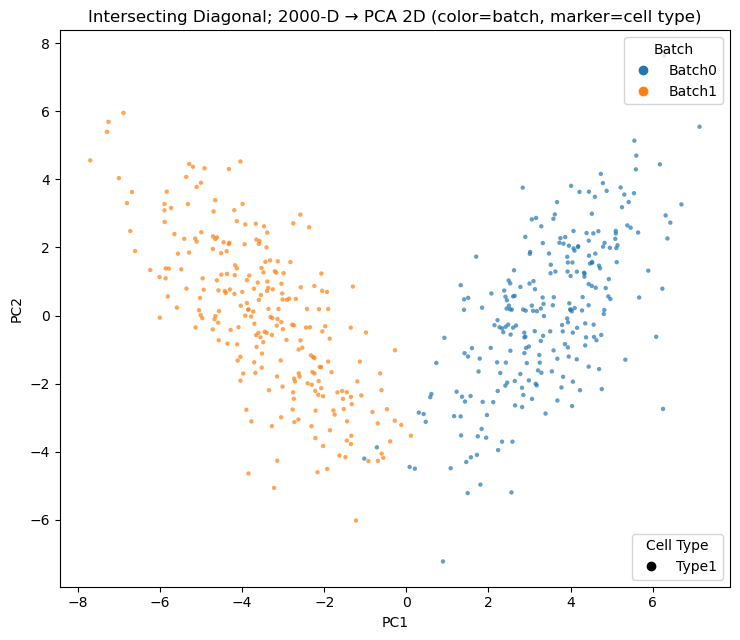

In [81]:
# Plot (color=batch, shape=cell type)
plot_pc2(PC, batches=batches, cell_types=cell_types,
         file="pca_sil_intersecting_diagonal.png",
         title="Intersecting Diagonal; 2000-D → PCA 2D (color=batch, marker=cell type)")

In [82]:
adata = sc.AnnData(X_highd)
adata

AnnData object with n_obs × n_vars = 500 × 2000

In [83]:
adata.obs['batch'] = batches
adata.obs['cell_type'] = cell_types
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'

In [84]:
adata.write("sil_intersecting_diagonal_n_genes_2000.h5ad")

### Rotate (more points intersecting)

In [85]:
# Generate the data
X, y = generate_intersecting_diagonal_ellipses(centers=[(-2, 1), (-1, 0)], angle_deg=30)

##### Part A

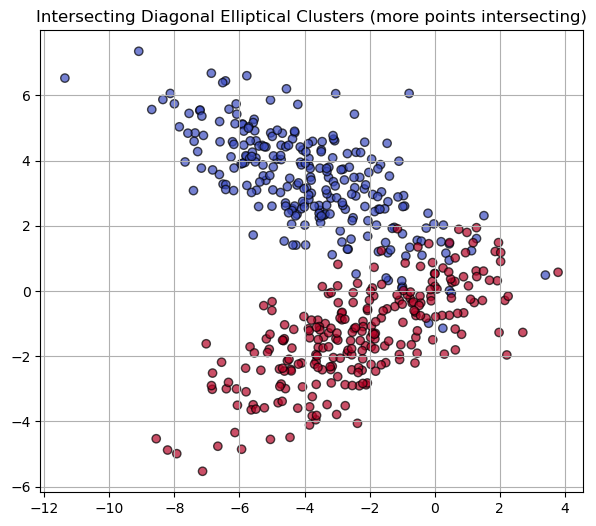

In [86]:
# Plot the data
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Intersecting Diagonal Elliptical Clusters (more points intersecting)")
plt.axis('equal')
plt.grid(True)
# plt.savefig("umap_sil_intersecting_diag_more_points.png", dpi=300, bbox_inches='tight')
plt.show()

In [87]:
cell_types = ['Type1'] * X.shape[0]
cell_types[:5]

['Type1', 'Type1', 'Type1', 'Type1', 'Type1']

In [88]:
batches = [f"Batch{b}" for b in y]
batches[:5]

['Batch0', 'Batch0', 'Batch0', 'Batch0', 'Batch0']

In [89]:
df = pd.DataFrame(X, columns=['X', 'Y'])
df['batch'] = batches
df['cell_type'] = cell_types

df

,X,Y,batch,cell_type
0,0.263462,2.020621,Batch0,Type1
1,-0.958351,2.924831,Batch0,Type1
2,-5.039006,4.848704,Batch0,Type1
3,-4.127174,3.949884,Batch0,Type1
4,-2.053209,2.155440,Batch0,Type1
...,...,...,...,...
495,-2.338470,-2.354000,Batch1,Type1
496,-8.205404,-4.880146,Batch1,Type1
497,-5.809749,-2.369315,Batch1,Type1
498,-2.354425,-2.503417,Batch1,Type1


In [90]:
pd.crosstab(df['batch'], df['cell_type'])

cell_type,Type1
batch,
Batch0,250
Batch1,250


In [91]:
adata = sc.AnnData(np.random.rand(X.shape[0], 400))
adata.obs = df

In [92]:
adata.obsm["X_pca"] = np.array(df[["X", "Y"]])
adata.obsm["X_umap"] = np.array(df[["X", "Y"]])

In [93]:
adata

AnnData object with n_obs × n_vars = 500 × 400
    obs: 'X', 'Y', 'batch', 'cell_type'
    obsm: 'X_pca', 'X_umap'

In [94]:
# adata.write("sil_intersecting_diagonal_more_points_intersect.h5ad")

##### Part B

In [95]:
X_highd, _ = from_2d_to_highd(X)
X_highd.shape, X_highd[:5]

((500, 2000),
 array([[ 0.07081771,  0.04416081,  0.09387806, ...,  0.18938488,
          0.02720795, -0.07927119],
        [ 0.09755332, -0.04837389,  0.12392094, ..., -0.07328235,
          0.08306078,  0.09066824],
        [ 0.18141662,  0.11054006,  0.03232303, ...,  0.15261133,
          0.25809468,  0.04041717],
        [ 0.13839104,  0.07962135, -0.22091793, ...,  0.20142587,
          0.02579068, -0.09224373],
        [ 0.03355729, -0.00295176, -0.15555411, ...,  0.08909606,
          0.04922486,  0.03864107]]))

In [96]:
PC, pca = pca2(X_highd)
PC.shape, PC[:5]

((500, 2),
 array([[-0.6891205 , -3.29006336],
        [ 0.86035593, -2.98931459],
        [ 4.23278813, -0.06459717],
        [ 3.04908736, -0.54177333],
        [ 0.54578909, -1.39207992]]))

In [97]:
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2])

Explained variance ratio (PC1, PC2): [0.26224069 0.1436996 ]


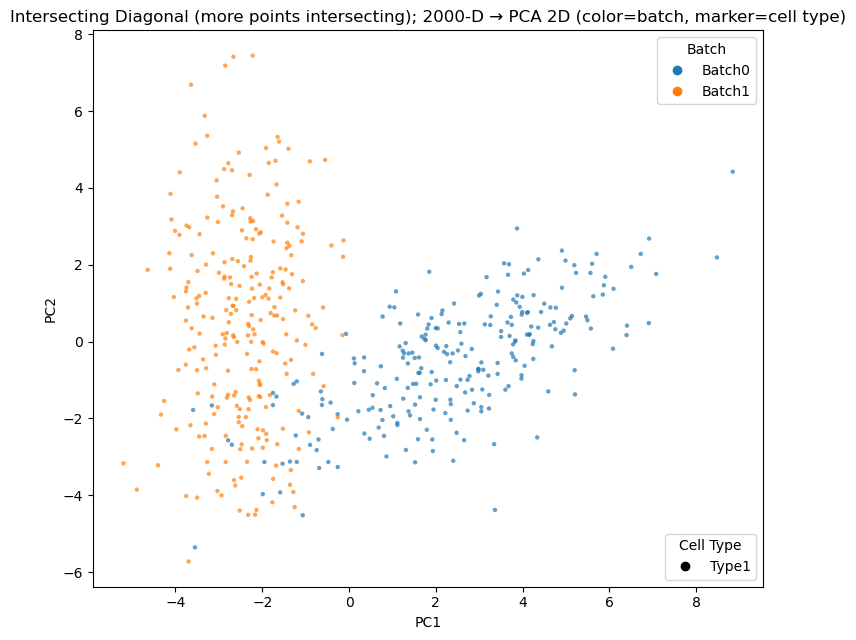

In [98]:
# Plot (color=batch, shape=cell type)
plot_pc2(PC, batches=batches, cell_types=cell_types,
         file="pca_sil_intersecting_diag_more_points.png",
         title="Intersecting Diagonal (more points intersecting); 2000-D → PCA 2D (color=batch, marker=cell type)")

In [99]:
adata = sc.AnnData(X_highd)
adata

AnnData object with n_obs × n_vars = 500 × 2000

In [100]:
adata.obs['batch'] = batches
adata.obs['cell_type'] = cell_types
adata

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'batch', 'cell_type'

In [101]:
adata.write("sil_intersecting_diagonal_more_points_intersect_n_genes_2000.h5ad")

In [102]:
print("End of the notebook")

End of the notebook
